In [3]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/Users/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
experiment_id = "Dop8V030"
# round_ids = ["ARN", "R01", "R01CS", "R02N", "R02F", "R02S", "R02SF"]
# round_ids = ["ARN", "R01", "R01CS", "R02N"]
round_ids = ["ARN", "R01", "R01CS", "R02N", "R02F", "R02S", "R02SF"]

dtype = torch.float32

In [5]:
sequences = []
for round_id in round_ids:
    s = utils.sequences_from_file(experiment_id, round_id, device=torch.device("cpu"))
    sequences.append(s)
    print(f"finished {round_id}")

finished ARN
finished R01
finished R01CS
finished R02N
finished R02F
finished R02S
finished R02SF


In [14]:
sequences_oh = [one_hot(seq).to(dtype=dtype, device=torch.device("cpu")) for seq in sequences]

In [15]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh])
fi0, _, _ = utils.frequences_from_sequences_oh(sequences_oh[0])

In [39]:
import importlib
importlib.reload(utils)
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(sampling)
importlib.reload(training)
importlib.reload(callback)

<module 'callback' from '/Users/scrotti/Aptamer2025py/callback.py'>

In [40]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")
tr.add_node(0, name = "R02F")
tr.add_node(0, name = "R02S")
tr.add_node(0, name = "R02SF")

picked_round_idx = [0, 1, 3, 4, 5, 6]

mode_names = ["NA, NW", "FA, NW", "NA, HW", "FA, HW"]

selected_modes = torch.BoolTensor(
    [[1, 0, 0, 0],
     [1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 0, 1, 0],
     [0, 0, 0, 1]]
)

n_selection_rounds, n_modes = selected_modes.size()
assert n_selection_rounds == len(picked_round_idx) - 1
n_rounds = n_selection_rounds + 1

In [41]:
L, q = sequences_oh[0][0].shape

k = torch.randn(L, q, dtype=dtype)
h = torch.randn(L, q, dtype=dtype)
J = utils.rand_coupling_matrix(L, q, dtype=dtype, rescaling=1e-4)
potts = energy_models.Potts(J, h)
potts_modes = [potts for _ in range(n_modes - 1)]

Ns0 = energy_models.IndepSites(k)
# unbound_mode = energy_models.ConstantEnergy(-10)

ps = selex_distribution.MultiModeDistribution(*potts_modes, unbound_mode, normalized=True)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes, 
                                                  learn_selection_strength=True,
                                                  selection_strength = torch.rand(n_selection_rounds, dtype=dtype))

In [42]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [55]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(sequences_oh[id], batch_size=batch_size, device=device) 
                for id in picked_round_idx]

In [61]:
n_chains = 10**4

chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [62]:
callbacks = [callback.ConvergenceMetricsCallback()]

In [68]:
model_device = model.to(device)
chains_device = chains.to(device)
total_reads_device = total_reads.to(device)
log_weights_device = log_weights.to(device)
optimizer = torch.optim.Adam(model_device.parameters(), lr=0.01)

In [ ]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 1000

training.train(model_device, data_loaders, total_reads_device, chains_device, n_sweeps, lr, max_epochs, target_pearson, 
               callbacks=callbacks, log_weights=log_weights_device, optimizer=optimizer)

 0.00%[                             ] Epoch: 0/1000 [00:00, ?it/s]

In [70]:
model = model_device.to(torch.device('cpu'))
chains = chains_device.to(torch.device('cpu'))
total_reads = total_reads_device.to(torch.device('cpu'))
log_weights = log_weights_device.to(torch.device('cpu'))

del model_device, chains_device, total_reads_device, log_weights_device
torch.cuda.empty_cache()

import gc
gc.collect()

32471

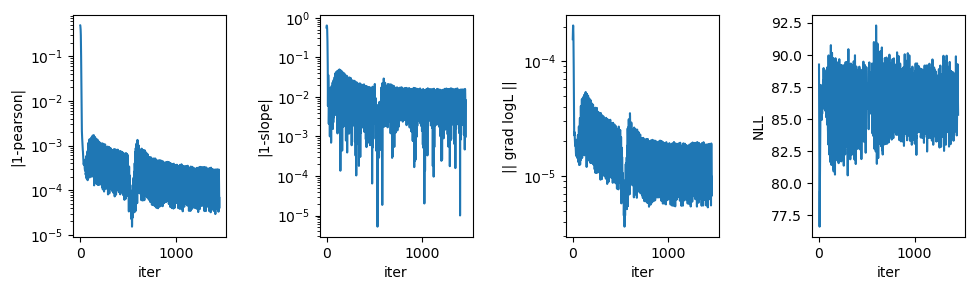

In [71]:
callbacks[0].plot();

In [72]:
model.selection_strength

Parameter containing:
tensor([0.0584, 1.5302, 0.9738, 1.3626, 1.1580], requires_grad=True)